## Importation des librairies 

In [3]:
from tqdm.notebook import tqdm
from importlib import reload
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import utilitaires
from utilitaires import psnr_from_model, load_data, train_model, function_for_comparison, plot_result, affiche_images, psnr_min_mean_max
from Models_Architectures import SUNet_CT_beginning

/home/id2180/pfe-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [4]:
CT = True               # Training with CT data or not
upscale = 2                     # Upscale factor (U) = 4
window_size = 32                 # Window size (W)
patch_size = 16 
embed_dim = 96                  # Embedding dimension (D) = 96
num_heads = [6,12]             # Default chosen in the document [3,6,12,24]
depths = [6, 6]                        # Number of encoder layers (L) = 4
output_channels = 1                # Number of channels for output images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64   
mlp_ratio = 2.  


epochs = 200             # Number of epochs
base_lr = 1e-4          # Base LR
batch_size = 64         # Penser à rendre le 64 normal
loss_fn = nn.MSELoss()
CT_message = "withCT_at_beginning" if CT else "withoutCT"
save_path = f'./Saved_models_after_08-02-24/model_sunet_{epochs}epochs_{window_size}windowsize_{patch_size}patchsize_{CT_message}_MSE.pth'


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
input_channels = 2 if CT else 1  # Number of channels for input images
print("Device :", device)
print("Channel number :", input_channels)
print(save_path)

Device : cpu
Channel number : 2
./Saved_models_after_08-02-24/model_sunet_200epochs_32windowsize_16patchsize_withCT_at_beginning_MSE.pth


## Import data

In [5]:
# Download data
type_data = ["low_edep", "high_edep", "ct"]
low_samp_data = load_data("MCsimulations", type_data[0])
high_samp_data = load_data("MCsimulations", type_data[1])
if CT:
    ct_data = load_data("MCsimulations", type_data[2])

# Transform data into tensors
low_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in low_samp_data]
high_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in high_samp_data]
if CT:
    ct_tensors = [torch.from_numpy(x).to(torch.float32) for x in ct_data]

In [6]:
import random

# List of patient indices from 1 to 82
index_patients = list(range(0, 82))

# Set the random seed for reproducibility
random.seed(1)

# Shuffle the list of patient indices
random.shuffle(index_patients)

# Assign indices to training, validation, and test sets
train_index = index_patients[:58]
val_index = index_patients[58:58+16]
test_index = index_patients[58+16:]

# Initialize lists to store training, validation, and test data
Low_train = []
High_train = []
CT_train = []

Low_val = []
High_val = []
CT_val = []

Low_test = []
High_test = []
CT_test = []

# Populate training data
for i in train_index:
    Low_train.extend(low_samp_tensors[i*80: (i+1)*80])
    High_train.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_train.extend(ct_tensors[i*80: (i+1)*80])

# Populate validation data
for i in val_index:
    Low_val.extend(low_samp_tensors[i*80: (i+1)*80])
    High_val.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_val.extend(ct_tensors[i*80: (i+1)*80])

# Populate test data
for i in test_index:
    Low_test.extend(low_samp_tensors[i*80: (i+1)*80])
    High_test.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_test.extend(ct_tensors[i*80: (i+1)*80])

print(f"The train data size is : {len(Low_train)}")
print(f"The validation data size is : {len(Low_val)}")
print(f"The test data size is : {len(Low_test)}")

The train data size is : 4640
The validation data size is : 1280
The test data size is : 640


In [7]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, low, high, ct=None):
        self.low = low
        self.high = high
        self.ct = ct

    def __len__(self):
        return len(self.low)

    def __getitem__(self, idx):
        X = self.low[idx]
        y = self.high[idx]
        
        if self.ct is not None:
            X = torch.stack([self.low[idx], self.ct[idx]], dim=0)
        
        return X, y
    
# DataLoader
if CT:
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train, CT_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val, CT_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test, CT_test),
                                batch_size=batch_size, shuffle=True)
else :
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test),
                                batch_size=batch_size, shuffle=True)

## Train SUNet

In [8]:
# Def the model
reload(SUNet_CT_beginning)
model_sunet = SUNet_CT_beginning.SUNet(img_size=input_size, patch_size=patch_size, input_channels=input_channels, 
                    output_channels=output_channels, embed_dim=embed_dim, depths=depths,
                    num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio, CT=CT,
                    qkv_bias=True, qk_scale=2, drop_rate=0., attn_drop_rate=0., 
                    drop_path_rate=0.1, norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                    use_checkpoint=False, final_upsample="Dual up-sample")
model_sunet.to(device)

# Optimiser
optimizer = torch.optim.Adam(model_sunet.parameters(), lr=base_lr)

# Learning rate schedular: Decay learning rate by a factor of 0.5 every 5 epochs:
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print('FLOPs: %.4f G' % (model_sunet.flops() / 1e9))
print('Number of parameters: %d' % (sum(p.numel() for p in model_sunet.parameters())))
print('Models parameters : ', model_sunet)

/home/id2180/pfe-venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


FLOPs: 0.0526 G
Number of parameters: 7701941
Models parameters :  SUNet(
  (prelu): PReLU(num_parameters=1)
  (conv_first): Conv2d(2, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (proj): Conv2d(96, 96, kernel_size=(16, 16), stride=(16, 16))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(4, 4), depth=6
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(4, 4), num_heads=6, window_size=4, shift_size=0, mlp_ratio=2.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(4, 4), num_heads=6
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bia

In [ ]:
reload(utilitaires)
start =time.time()
# Model training
model_sunet, loss_train, loss_val, list_pred = utilitaires.train_model(
    model=model_sunet,
    criterion=loss_fn, 
    optimizer=optimizer,
    dataloaders={'train' : dataloader_train, 'val' : dataloader_val},
    device=device,
    n_epochs=epochs, 
    save_path=save_path,
)
end = time.time() - start

# Affichage du PSNR 
min_psnr, mean_psnr, max_psnr = utilitaires.psnr_min_mean_max(dataloader_test, model_path = save_path, model = model_sunet, 
                                                  batch_size = batch_size, ct = CT)
print(f"Minimum PSNR : {min_psnr} \n Moyenne PSNR : {mean_psnr} \n Maximum PSNR : {max_psnr}" )

Epoch 1
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.183668
Validation set:   Avg loss: 0.050193

Epoch 2
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.096461
Validation set:   Avg loss: 0.026272

Epoch 3
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.075266
Validation set:   Avg loss: 0.020501

Epoch 4
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.062042
Validation set:   Avg loss: 0.016935

Epoch 5
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.020102
Validation set:   Avg loss: 0.005534

Epoch 33
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.019034
Validation set:   Avg loss: 0.005429

Epoch 149
-----------------

In [ ]:
torch.save(model_sunet.state_dict(), save_path)

In [9]:
min_psnr, mean_psnr, max_psnr = utilitaires.psnr_min_mean_max(dataloader_test, model_path = save_path, model = model_sunet, 
                                                  batch_size = batch_size, ct = CT)
print(f"Minimum PSNR : {min_psnr} \n Moyenne PSNR : {mean_psnr} \n Maximum PSNR : {max_psnr}" )

/home/id2180/pfe-venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


Minimum PSNR : 25.332447052001953 
 Moyenne PSNR : 35.37305938005447 
 Maximum PSNR : 43.26530838012695


In [1]:
print(f'Temps mis :  {end}, soit {time.strftime("%H:%M:%S", time.gmtime(end))}')

NameError: name 'end' is not defined

In [15]:
start

1709413832.194804

In [13]:
fin = time.time()-6*60*60
fin


1709571600.4183016

In [16]:
execution_time = fin - start
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

19:49:28


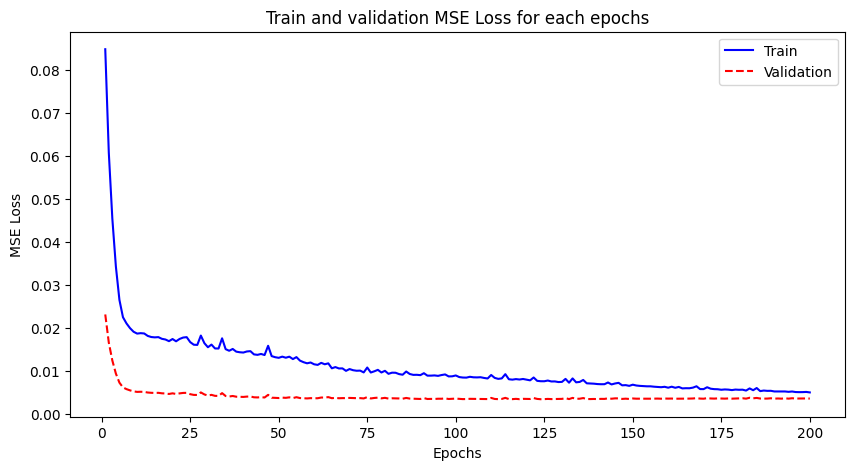

In [193]:
# Evolution of the training
plot_result(loss_train, loss_val, "MSE Loss")

torch.Size([64, 64])
torch.Size([64, 64])


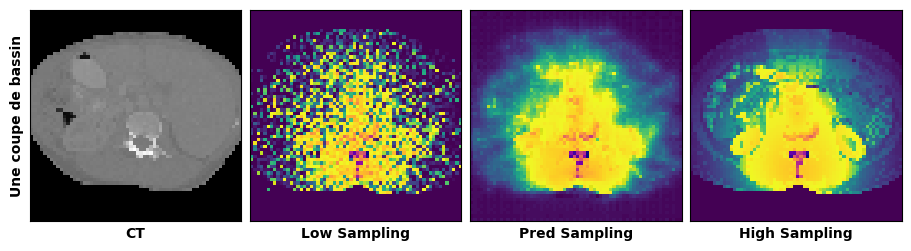

In [194]:
path_to_load = save_path
reload(utilitaires)
# Chargement du modèle et représentation graphique des résultats
utilitaires.function_for_comparison(model_path=path_to_load, 
                        dataloader = dataloader_test, 
                        ind = 20, 
                        model = model_sunet, CT = CT)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np


for image in list_pred :
     ##### Une mode de CMP############
    top = cm.get_cmap('viridis', 64)
    bottom = cm.get_cmap('plasma', 960)
    newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                        bottom(np.linspace(1, 0, 960))))
    newcmp = ListedColormap(newcolors, name='MonteCarlo')

    fig1 = plt.figure(constrained_layout=True, figsize=(9, 3))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
    #
    ax1a = fig1.add_subplot(spec[0])
    plt.imshow(image, interpolation=None, cmap=newcmp)
    #plt.ylabel('Une coupe de bassin',fontweight='bold')
    plt.xlabel('Image',fontweight='bold')
    plt.xticks([], [])
    plt.yticks([], [])
    
    ###########
    plt.show()

In [110]:
list_pred[1].shape

torch.Size([64, 64])

In [258]:
for i in range(50) : 
    print(psnr_from_model(dataloader_test, i, save_path, model_sunet))

tensor(32.4867)
tensor(37.5326)
tensor(39.5104)
tensor(37.9383)
tensor(38.1958)
tensor(35.7078)
tensor(36.2642)
tensor(40.4282)
tensor(39.1056)
tensor(37.2236)
tensor(37.4581)
tensor(39.2135)
tensor(40.6340)
tensor(42.2531)
tensor(39.5547)
tensor(37.2936)
tensor(36.1712)
tensor(40.1141)
tensor(42.7232)
tensor(39.5104)
tensor(39.7011)
tensor(37.4442)
tensor(39.4308)
tensor(36.2115)
tensor(37.3476)
tensor(39.7812)
tensor(38.9245)
tensor(34.9137)
tensor(39.6504)
tensor(33.7284)
tensor(42.1097)
tensor(37.2027)
tensor(36.4266)
tensor(38.1318)
tensor(37.2722)
tensor(40.7775)
tensor(37.1870)
tensor(38.6202)
tensor(37.2956)
tensor(37.9695)
tensor(38.7988)
tensor(36.7890)
tensor(37.8485)
tensor(39.7795)
tensor(40.1019)
tensor(40.7985)
tensor(36.7451)
tensor(36.2115)
tensor(40.6340)
tensor(38.2226)
